In [28]:
import os
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define custom dataset class
class AnemiaDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load image filenames and their corresponding labels
        for filename in os.listdir(data_dir):
            if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
                # Check if the image name starts with "Anemic" or "Non-Anemic"
                if filename.startswith("Anemic"):
                    label = 1  # Anemic
                elif filename.startswith("Non-Anemic"):
                    label = 0  # Non-Anemic
                else:
                    continue  # Skip images with unexpected filenames
                
                # Append the full path and label
                self.image_paths.append(os.path.join(data_dir, filename))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load the image
        image = Image.open(img_path).convert('RGB')  # Ensure 3 channels (RGB)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transform to resize and normalize images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

# Define the path to the data folder
dataset_dir = r".\anemia_detection\Palm"

# Create custom dataset
dataset = AnemiaDataset(data_dir=dataset_dir, transform=transform)

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [29]:
from torchvision import models

# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for binary classification (2 classes)
model.fc = nn.Linear(model.fc.in_features, 1)  # Output size = 1 for binary classification
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available


In [4]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)
torch.cuda.is_available()



In [ ]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze()  # Remove extra dimensions for binary classification
            loss = criterion(outputs, labels.float())  # Compute loss
            loss.backward()  # Backpropagate

            # Update weights
            optimizer.step()

            # Compute accuracy
            predicted = torch.round(torch.sigmoid(outputs))  # Get predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            running_loss += loss.item()

        # Calculate training accuracy and loss
        train_accuracy = correct / total
        train_loss = running_loss / len(train_loader)

        # Evaluate on validation data
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = model(inputs)
                outputs = outputs.squeeze()

                # Compute loss and accuracy
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()

                predicted = torch.round(torch.sigmoid(outputs))
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        val_loss = val_loss / len(val_loader)

        # Print results for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Save the best model based on validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt',_use_new_zipfile_serialization=True,pickle_protocol=4)
            torch.save(model.state_dict(), 'best_model.pth',_use_new_zipfile_serialization=True,pickle_protocol=4)

    print("Training complete.")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model on the validation set
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(inputs)
        outputs = outputs.squeeze()

        predicted = torch.round(torch.sigmoid(outputs))
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Final Validation Accuracy: {accuracy:.4f}")


In [ ]:
'_____________________________________'

In [ ]:
import torch
from torchvision import transforms, models
from PIL import Image
import os

# Function to load the trained model
def load_model(model_path='best_model.pth'):
    # Load pre-trained ResNet50 model and modify for binary classification
    model = models.resnet50(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, 1)  # Output size = 1 for binary classification
    model.load_state_dict(torch.load(model_path))  # Load the saved weights
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Move to GPU if available
    model.eval()  # Set the model to evaluation mode
    return model

# Function to preprocess the image
def preprocess_image(image_path):
    # Define the transforms (same as used in training)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image to 224x224
        transforms.ToTensor(),  # Convert the image to a Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats
    ])

    # Open the image file and apply the transformations
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    image = transform(image)
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

# Function to make predictions
def predict_anemia(model, image_path):
    # Preprocess the input image
    image = preprocess_image(image_path)
    
    # Move image to the same device as the model (GPU or CPU)
    image = image.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Forward pass through the model to get the prediction
    with torch.no_grad():
        output = model(image)  # Output is a single value

    # Apply sigmoid to the output to get a probability
    probability = torch.sigmoid(output).item()  # Convert the output to a scalar probability

    # If the probability is greater than 0.5, we classify it as "Anemic" (1)
    if probability > 0.5:
        return "Anemic", probability
    else:
        return "Non-Anemic", probability

# Example usage of the functions
if __name__ == '__main__':
    image_path = r'C:\projs\anemia_project\Non-AnemicP-040 (5).png'

    # Load the trained model
    model = load_model()

    # Make prediction on the input image
    label, probability = predict_anemia(model, image_path)
    
    # Print the result
    print(f"The person is predicted to be: {label}")
    print(f"Prediction probability: {probability:.4f}")


##### Real Data Training

In [28]:
# import os
# from wand.image import Image

# def convert_heic_to_jpg_wand(data_dir):
#     # Walk through the directory
#     for root, dirs, files in os.walk(data_dir):
#         for file in files:
#             # Check if the file is a HEIC file
#             if file.lower().endswith('.heic'):
#                 heic_file_path = os.path.join(root, file)
                
#                 # Print the HEIC file name
#                 print(f"Processing: {file}")
                
#                 # Convert HEIC to JPG using Wand
#                 try:
#                     with Image(filename=heic_file_path) as img:
#                         img.format = 'jpeg'
#                         jpg_file_path = os.path.splitext(heic_file_path)[0] + '.jpg'
#                         img.save(filename=jpg_file_path)

#                     # Delete the original HEIC file after conversion
#                     os.remove(heic_file_path)
#                     print(f"Converted and deleted: {file}")
#                 except Exception as e:
#                     print(f"Failed to process {file}: {e}")

# # Define your dataset directory
# dataset_dir = r'.\real_data'

# # Call the function to convert HEIC files to JPG and delete them
# convert_heic_to_jpg_wand(dataset_dir)


Processing: eyes.HEIC
Converted and deleted: eyes.HEIC
Processing: lips.HEIC
Converted and deleted: lips.HEIC
Processing: nails.HEIC
Converted and deleted: nails.HEIC
Processing: palm.HEIC
Converted and deleted: palm.HEIC
Processing: tongue.HEIC
Converted and deleted: tongue.HEIC
Processing: eyes.HEIC
Converted and deleted: eyes.HEIC
Processing: lips.HEIC
Converted and deleted: lips.HEIC
Processing: nails.HEIC
Converted and deleted: nails.HEIC
Processing: palm.HEIC
Converted and deleted: palm.HEIC
Processing: tongue.HEIC
Converted and deleted: tongue.HEIC
Processing: eyes.HEIC
Converted and deleted: eyes.HEIC
Processing: lips.HEIC
Converted and deleted: lips.HEIC
Processing: nails.HEIC
Converted and deleted: nails.HEIC
Processing: palm.HEIC
Converted and deleted: palm.HEIC
Processing: tongue.HEIC
Converted and deleted: tongue.HEIC
Processing: eyes.HEIC
Converted and deleted: eyes.HEIC
Processing: lips.HEIC
Converted and deleted: lips.HEIC
Processing: nails.HEIC
Converted and deleted: n

In [24]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

# List of possible image extensions
image_formats = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG', '.heic', '.HEIC'}

def get_image_files(patient_path):
    """ Get all image files in a patient's folder """
    image_files = []
    for file in os.listdir(patient_path):
        if any(file.lower().endswith(ext) for ext in image_formats):
            image_files.append(os.path.join(patient_path, file))
    return image_files

class AnemiaDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Walk through the dataset directories (IRON DEFICIENCY ANEMIA and NON - IRON DEFICIENCY ANEMIA)
        for condition in ['IRON DEFICIENCY ANEMIA', 'NON - IRON DEFICIENCY ANEMIA']:
            condition_path = os.path.join(data_dir, condition)
            if not os.path.exists(condition_path):
                continue
            
            # Iterate through each patient folder
            for patient_folder in os.listdir(condition_path):
                patient_path = os.path.join(condition_path, patient_folder)
                if os.path.isdir(patient_path):
                    # Get all image files for the patient (regardless of their name)
                    img_files = get_image_files(patient_path)
                    
                    # If any images are found, add them to the dataset
                    for img_path in img_files:
                        self.image_paths.append(img_path)
                        # Set label: 1 for "IRON DEFICIENCY ANEMIA", 0 for "NON - IRON DEFICIENCY ANEMIA"
                        self.labels.append(1 if condition == 'IRON DEFICIENCY ANEMIA' else 0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load the image
        image = Image.open(img_path).convert('RGB')  # Ensure it's RGB format
        
        # Apply any transformations (resize, normalize, etc.)
        if self.transform:
            image = self.transform(image)

        return image, label


# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Slightly larger for random crop
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.15, 0.15), scale=(0.8, 1.2)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the path to your dataset
dataset_dir = r".\real_data"

# Create the custom dataset
dataset = AnemiaDataset(data_dir=dataset_dir, transform=transform)

# Print the total number of images found
print(f"Total number of images found: {len(dataset)}")

# Split the dataset into training and validation
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Example of how to access the data
train_labels=[]
for images, labels in train_loader:
    print(images.shape)  # Batch of images
    train_labels.append(labels)      # Corresponding labels
    break


Total number of images found: 441
torch.Size([64, 3, 224, 224])


In [25]:
# Collect all training labels
all_train_labels = []

for images, labels in train_loader:
    all_train_labels.extend(labels.tolist())  # Convert tensor to list and extend the list

# Convert the list of labels to a tensor
# all_train_labels = torch.tensor(all_train_labels)

# Print the collected training labels
print(all_train_labels)
print(len(all_train_labels))

[0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 

In [3]:
import os

# Define the dataset directory
dataset_dir = r".\real_data"

# List of possible image extensions
image_formats = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG', '.heic', '.HEIC'}

def get_image_files(patient_path):
    """ Get all image files in a patient's folder """
    image_files = []
    for file in os.listdir(patient_path):
        if any(file.lower().endswith(ext) for ext in image_formats):
            image_files.append(os.path.join(patient_path, file))
    return image_files

# Dictionary to store patient image counts
patient_image_counts = {}

# Iterate through conditions
for condition in ['IRON DEFICIENCY ANEMIA', 'NON - IRON DEFICIENCY ANEMIA']:
    condition_path = os.path.join(dataset_dir, condition)
    if not os.path.exists(condition_path):
        continue
    
    # Iterate through each patient folder
    for patient_folder in os.listdir(condition_path):
        patient_path = os.path.join(condition_path, patient_folder)
        if os.path.isdir(patient_path):
            img_files = get_image_files(patient_path)
            patient_image_counts[patient_folder] = len(img_files)

# Find patients with incorrect image counts
incorrect_patients = {patient: count for patient, count in patient_image_counts.items() if count != 5}

# Print the results
if incorrect_patients:
    print("Patients with incorrect image counts:")
    for patient, count in incorrect_patients.items():
        print(f"Patient: {patient}, Image Count: {count}")
else:
    print("All patients have exactly 5 images.")


Patients with incorrect image counts:
Patient: PATIENT 19, Image Count: 4
Patient: PATIENT 29, Image Count: 6


In [11]:
len(train_labels[0].tolist())

32

Using device: cuda


c:\projs\anemia_project\cudavenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\projs\anemia_project\cudavenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\projs\anemia_project\cudavenv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25


Training: 100%|██████████| 6/6 [00:14<00:00,  2.48s/it]


Train Loss: 0.6934, Train Accuracy: 49.72%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


Validation Loss: 0.6831, Validation Accuracy: 55.06%
Epoch 2/25


Training: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


Train Loss: 0.6606, Train Accuracy: 61.93%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


Validation Loss: 0.6669, Validation Accuracy: 60.67%
Epoch 3/25


Training: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


Train Loss: 0.6622, Train Accuracy: 60.51%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


Validation Loss: 0.6385, Validation Accuracy: 71.91%
Epoch 4/25


Training: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


Train Loss: 0.6475, Train Accuracy: 64.49%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


Validation Loss: 0.6286, Validation Accuracy: 73.03%
Epoch 5/25


Training: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


Train Loss: 0.6272, Train Accuracy: 66.48%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


Validation Loss: 0.6527, Validation Accuracy: 65.17%
Epoch 6/25
Unfreezing ResNet layer4 for fine-tuning


Training: 100%|██████████| 6/6 [00:14<00:00,  2.50s/it]


Train Loss: 0.5926, Train Accuracy: 70.45%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


Validation Loss: 0.5677, Validation Accuracy: 69.66%
Epoch 7/25


Training: 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


Train Loss: 0.5265, Train Accuracy: 76.42%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


Validation Loss: 0.6042, Validation Accuracy: 68.54%
Epoch 8/25


Training: 100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


Train Loss: 0.3793, Train Accuracy: 82.95%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


Validation Loss: 0.4388, Validation Accuracy: 79.78%
Epoch 9/25


Training: 100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


Train Loss: 0.3169, Train Accuracy: 86.65%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


Validation Loss: 0.3323, Validation Accuracy: 86.52%
Epoch 10/25


Training: 100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


Train Loss: 0.2671, Train Accuracy: 90.34%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


Validation Loss: 0.4211, Validation Accuracy: 86.52%
Epoch 11/25


Training: 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


Train Loss: 0.2388, Train Accuracy: 90.62%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


Validation Loss: 0.4849, Validation Accuracy: 83.15%
Epoch 12/25


Training: 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


Train Loss: 0.2179, Train Accuracy: 92.61%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


Validation Loss: 0.4496, Validation Accuracy: 85.39%
Epoch 13/25


Training: 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


Train Loss: 0.1608, Train Accuracy: 93.47%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


Validation Loss: 0.5720, Validation Accuracy: 85.39%
Epoch 14/25


Training: 100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


Train Loss: 0.1718, Train Accuracy: 95.74%


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

Validation Loss: 0.4623, Validation Accuracy: 83.15%
Early stopping triggered.
Training complete. Best model saved as 'best_anemia_model.pth'.


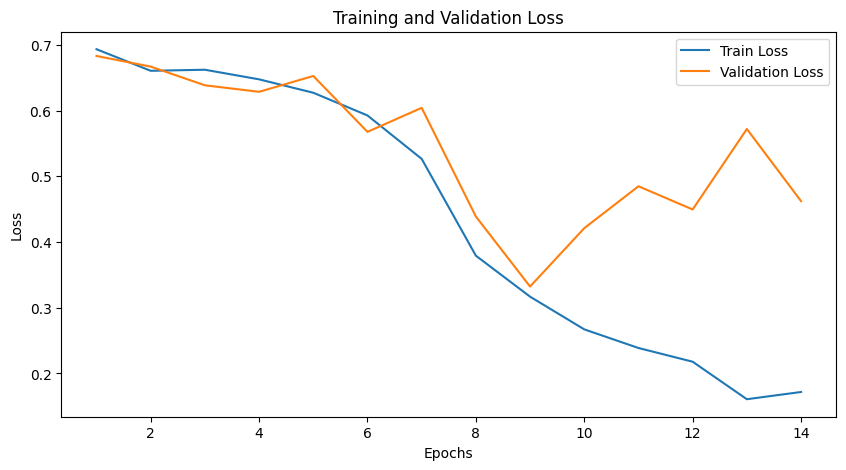

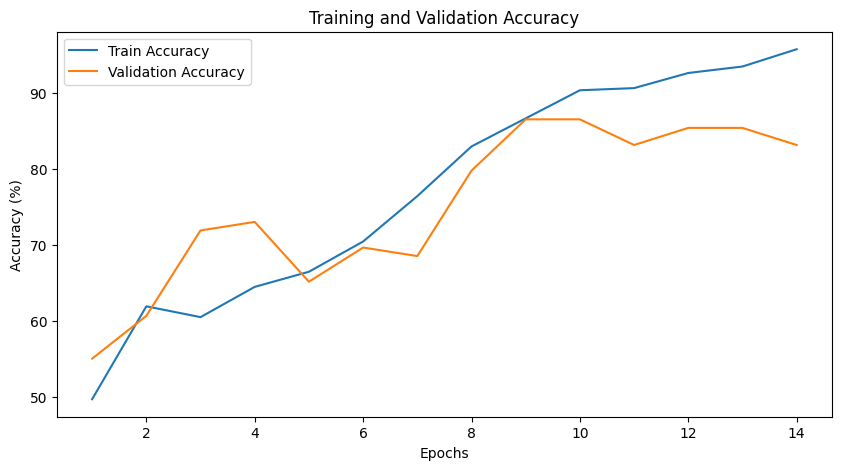

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm import tqdm  # For progress bar
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# Define data transformations with additional augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Check if GPU (CUDA) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load a pre-trained ResNet model and modify the final layer for binary classification
model = models.resnet50(pretrained=True)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout for regularization
    nn.Linear(512, 2)
)

# Move model to device
model = model.to(device)

# Compute class weights (adjust labels accordingly)
your_train_labels = all_train_labels
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=your_train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss function with class weighting
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct_predictions, total_predictions = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions * 100
    return avg_loss, accuracy

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss, correct_predictions, total_predictions = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions * 100
    return avg_loss, accuracy

# Training loop with early stopping and layer unfreezing
num_epochs = 25
best_val_loss = float('inf')
early_stopping_patience = 5
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Unfreeze last ResNet block after 5 epochs
    if epoch == 5:
        for param in model.layer4.parameters():
            param.requires_grad = True
        print("Unfreezing ResNet layer4 for fine-tuning")

    # Training phase
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_anemia_model.pth')  # Save best model
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break  # Stop training

print("Training complete. Best model saved as 'best_anemia_model.pth'.")


In [42]:
# torch.save(model.state_dict(), 'best_anemia_model.pth') 
torch.save(model.state_dict(), 'best_anemia_model.pt',_use_new_zipfile_serialization=True,pickle_protocol=4)
torch.save(model.state_dict(), 'best_anemia_model.pth',_use_new_zipfile_serialization=True,pickle_protocol=4)

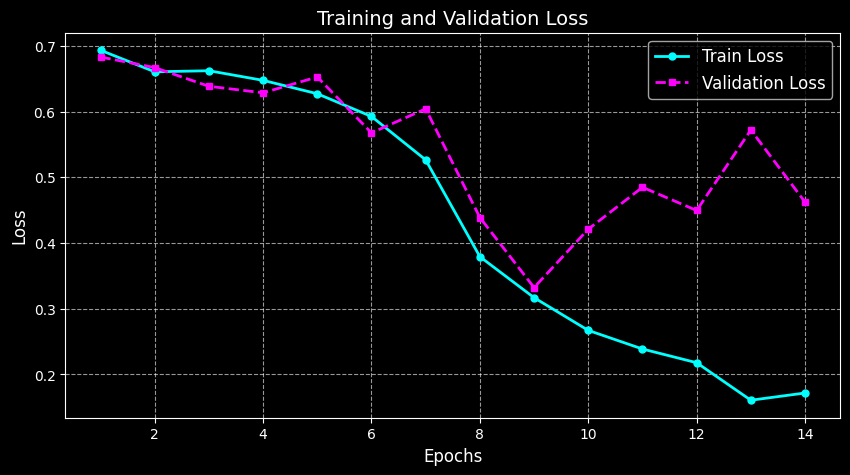

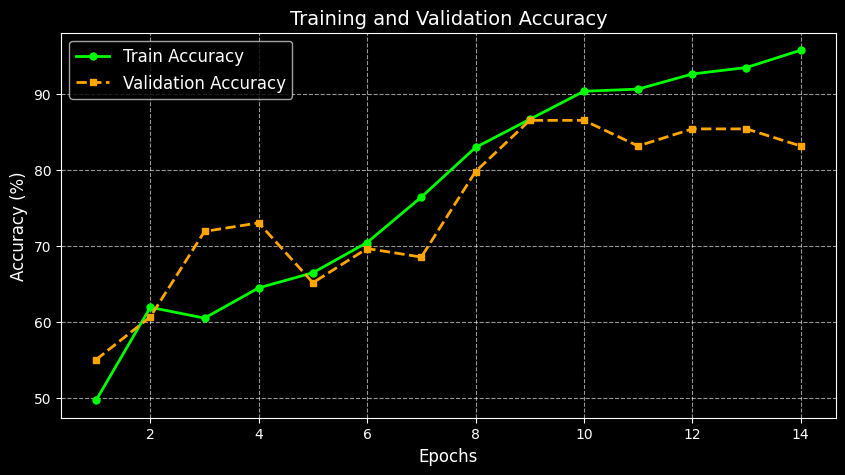

In [29]:
import os
import matplotlib.pyplot as plt

# Set dark cool theme
plt.style.use('dark_background')

# Create the visualizations directory if it doesn't exist
os.makedirs("visualizations", exist_ok=True)

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, len(train_losses) + 1), 
    train_losses, 
    label='Train Loss', 
    marker='o',  # Add markers for data points
    markersize=5,  # Adjust marker size
    linestyle='-',  # Solid line
    linewidth=2,  # Thicker line
    color='cyan'  # Cool color for train loss
)
plt.plot(
    range(1, len(val_losses) + 1), 
    val_losses, 
    label='Validation Loss', 
    marker='s',  # Add markers for data points
    markersize=5,  # Adjust marker size
    linestyle='--',  # Dashed line
    linewidth=2,  # Thicker line
    color='magenta'  # Cool color for validation loss
)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability
plt.savefig(
    os.path.join("visualizations", "training_validation_loss.png"),
    dpi=300,  # High resolution
    bbox_inches='tight'
)
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, len(train_accuracies) + 1), 
    train_accuracies, 
    label='Train Accuracy', 
    marker='o',  # Add markers for data points
    markersize=5,  # Adjust marker size
    linestyle='-',  # Solid line
    linewidth=2,  # Thicker line
    color='lime'  # Cool color for train accuracy
)
plt.plot(
    range(1, len(val_accuracies) + 1), 
    val_accuracies, 
    label='Validation Accuracy', 
    marker='s',  # Add markers for data points
    markersize=5,  # Adjust marker size
    linestyle='--',  # Dashed line
    linewidth=2,  # Thicker line
    color='orange'  # Cool color for validation accuracy
)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability
plt.savefig(
    os.path.join("visualizations", "training_validation_accuracy.png"),
    dpi=300,  # High resolution
    bbox_inches='tight'
)
plt.show()

In [38]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, test_loader, device, save_dir='visualizations'):
    # Create visualizations directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            # Collecting labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Generate classification report
    report = classification_report(all_labels, all_predictions, output_dict=True)
    
    # Save classification report as markdown
    report_path = os.path.join(save_dir, 'classification_report.md')
    with open(report_path, 'w') as f:
        f.write("# Classification Report\n\n")
        f.write("## Metrics by Class\n\n")
        f.write("| Class | Precision | Recall | F1-Score | Support |\n")
        f.write("|-------|-----------|--------|----------|----------|\n")
        
        for class_name, metrics in report.items():
            if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                f.write(f"| {class_name} | {metrics['precision']:.2f} | {metrics['recall']:.2f} | {metrics['f1-score']:.2f} | {metrics['support']} |\n")
        
        f.write("\n## Overall Metrics\n\n")
        f.write(f"- **Accuracy**: {report['accuracy']:.2f}\n")
        f.write(f"- **Macro Avg Precision**: {report['macro avg']['precision']:.2f}\n")
        f.write(f"- **Macro Avg Recall**: {report['macro avg']['recall']:.2f}\n")
        f.write(f"- **Macro Avg F1-Score**: {report['macro avg']['f1-score']:.2f}\n")
    
    # Confusion Matrix with Dark Theme
    plt.figure(figsize=(8, 6), facecolor='#2C3E50')
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Dark theme heatmap
    sns.heatmap(cm, annot=True, fmt='d', 
                cmap='crest', 
                cbar=False,
                xticklabels=['Non-Anemic', 'Anemic'], 
                yticklabels=['Non-Anemic', 'Anemic'],
                linewidths=0.5,
                linecolor='gray',
                square=True,
                # Customize text color and background
                annot_kws={'color': 'white', 'fontweight': 'bold'},
                )
    
    # Customize plot aesthetics
    plt.title('Confusion Matrix', color='white', fontsize=15, fontweight='bold')
    plt.ylabel('Actual', color='white')
    plt.xlabel('Predicted', color='white')
    plt.xticks(color='white')
    plt.yticks(color='white')
    
    # Set dark background
    plt.gca().set_facecolor('#2C3E50')
    
    # Save the plot
    plt.tight_layout()
    save_path = os.path.join(save_dir, 'confusion_matrix.png')
    plt.savefig(save_path, facecolor='#2C3E50', edgecolor='none', dpi=300)
    plt.close()

    print(f"Classification report saved to {report_path}")
    print(f"Confusion matrix saved to {save_path}")

# Usage remains the same
evaluate_model(model, val_loader, device)

Classification report saved to visualizations\classification_report.md
Confusion matrix saved to visualizations\confusion_matrix.png


#### Testing On Images

In [62]:
import torch
from torchvision import transforms
from PIL import Image

# Define the transformation (same as in training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size (224x224 for ResNet)
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])


# Load the trained model (make sure to load the weights)
# Use ResNet50 instead of ResNet18 if it was used during training
model = models.resnet50(pretrained=False)  # Don't use pre-trained weights, load our own
model.fc = nn.Linear(model.fc.in_features, 2)  # Modify the final layer for 2 output classes
model.load_state_dict(torch.load('best_anemia_model.pth'))  # Load the saved weights
model.eval()  # Set model to evaluation mode

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Function to predict the class of an individual image
def predict_image(image_path, model, transform, device):
    # Open the image
    image = Image.open(image_path).convert('RGB')  # Ensure it's RGB format

    # Apply transformations (resize, normalize, etc.)
    image = transform(image)
    
    # Add batch dimension (model expects a batch, even if it's size 1)
    image = image.unsqueeze(0).to(device)

    # Forward pass: get the model's prediction
    with torch.no_grad():  # No need to calculate gradients during inference
        outputs = model(image)
        print(outputs)
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

    # Convert the prediction to label: 0 or 1 (Non-Anemic, Anemic)
    label = 'Anemic' if predicted.item() == 1 else 'Non-Anemic'
    return label

# Test the prediction function
image_path = r"C:\projs\anemia_project\real_data\NON - IRON DEFICIENCY ANEMIA\PATIENT 14\palm.jpg"  # Replace with your image path

predicted_class = predict_image(image_path, model, transform, device)
print(f"Predicted Class: {predicted_class}")


C:\Users\rohan\AppData\Local\Temp\ipykernel_25616\890168189.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_anemia_model.pth'))  

tensor([[0.0420, 0.8649]], device='cuda:0')
Predicted Class: Anemic


In [56]:
import os
import torch
from torchvision import models
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

image_path = r"C:\projs\anemia_project\real_data\NON - IRON DEFICIENCY ANEMIA\PATIENT 14\tongue.png"  # Replace with your image path
def visualize_feature_maps(image_path, model, transform, device, save_dir='visualizations'):
    # Create visualizations directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Reset feature maps list
    feature_maps.clear()
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Forward pass: Get the feature maps
    with torch.no_grad():
        model(image_tensor)

    # Prepare visualization
    num_feature_maps = feature_maps[0].shape[1]
    
    # Create a dark-themed figure
    plt.figure(figsize=(20, 20), facecolor='#2C3E50')
    
    # Calculate grid dimensions
    grid_size = min(int(num_feature_maps**0.5) + 1, 8)
    
    for i in range(min(num_feature_maps, grid_size**2)):
        plt.subplot(grid_size, grid_size, i + 1)
        feature_map = feature_maps[0][0, i].cpu()
        plt.imshow(feature_map, cmap='crest')
        plt.title(f'FM {i+1}', color='white', fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    
    # Generate filename based on input image
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    save_path = os.path.join(save_dir, f'Non_{base_filename}_feature_maps.png')
    
    # Save the figure
    plt.savefig(save_path, 
                facecolor='#2C3E50', 
                edgecolor='none', 
                dpi=300,
                bbox_inches='tight')
    
    plt.close()
    
    print(f"Feature maps saved to {save_path}")

# Setup for feature map extraction
def hook_fn(module, input, output):
    feature_maps.append(output)

# Global feature maps list
feature_maps = []

# Function to setup model for feature map extraction
def setup_feature_map_extraction(model):
    # Remove any existing hooks
    for hook in hooks:
        hook.remove()
    hooks.clear()
    
    # Register hook to the last convolutional block
    hooks.append(
        model.layer4[2].conv1.register_forward_hook(hook_fn)
    )

# Global hooks list
hooks = []

# Usage example (commented out)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('best_anemia_model.pth'))
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

setup_feature_map_extraction(model)
visualize_feature_maps(image_path, model, transform, device)


C:\Users\rohan\AppData\Local\Temp\ipykernel_25616\1275989665.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_anemia_model.pth'))


Feature maps saved to visualizations\Non_tongue_feature_maps.png


In [57]:
import os
import torch
from torchvision import models
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

image_path = r"C:\projs\anemia_project\real_data\IRON DEFICIENCY ANEMIA\PATIENT 14\tongue.jpg"  # Replace with your image path
def visualize_feature_maps(image_path, model, transform, device, save_dir='visualizations'):
    # Create visualizations directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Reset feature maps list
    feature_maps.clear()
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Forward pass: Get the feature maps
    with torch.no_grad():
        model(image_tensor)

    # Prepare visualization
    num_feature_maps = feature_maps[0].shape[1]
    
    # Create a dark-themed figure
    plt.figure(figsize=(20, 20), facecolor='#2C3E50')
    
    # Calculate grid dimensions
    grid_size = min(int(num_feature_maps**0.5) + 1, 8)
    
    for i in range(min(num_feature_maps, grid_size**2)):
        plt.subplot(grid_size, grid_size, i + 1)
        feature_map = feature_maps[0][0, i].cpu()
        plt.imshow(feature_map, cmap='crest')
        plt.title(f'FM {i+1}', color='white', fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    
    # Generate filename based on input image
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    save_path = os.path.join(save_dir, f'Deficency_{base_filename}_feature_maps.png')
    
    # Save the figure
    plt.savefig(save_path, 
                facecolor='#2C3E50', 
                edgecolor='none', 
                dpi=300,
                bbox_inches='tight')
    
    plt.close()
    
    print(f"Feature maps saved to {save_path}")

# Setup for feature map extraction
def hook_fn(module, input, output):
    feature_maps.append(output)

# Global feature maps list
feature_maps = []

# Function to setup model for feature map extraction
def setup_feature_map_extraction(model):
    # Remove any existing hooks
    for hook in hooks:
        hook.remove()
    hooks.clear()
    
    # Register hook to the last convolutional block
    hooks.append(
        model.layer4[2].conv1.register_forward_hook(hook_fn)
    )

# Global hooks list
hooks = []

# Usage example (commented out)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('best_anemia_model.pth'))
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

setup_feature_map_extraction(model)
visualize_feature_maps(image_path, model, transform, device)


C:\Users\rohan\AppData\Local\Temp\ipykernel_25616\2746994373.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_anemia_model.pth'))


Feature maps saved to visualizations\Deficency_tongue_feature_maps.png


In [20]:
# torch.save(model.state_dict(), 'anemic_real.pt',_use_new_zipfile_serialization=True,pickle_protocol=4)
# torch.save(model.state_dict(), 'anemic_real.pth',_use_new_zipfile_serialization=True,pickle_protocol=4)